In [1]:
from ceed.models.ceed import CEED
import numpy as np
import os
import matplotlib.pyplot as plt
from analysis.projections import learn_manifold_umap, pca_train, pca
import colorcet as cc
import torch

from mpl_toolkits.mplot3d import Axes3D

2023-10-09 17:50:42.157262: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-09 17:50:42.157290: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-09 17:50:42.157312: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-09 17:50:42.163793: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-09 17:50:42.907237: W tensorflow/compiler/

In [2]:
# example cell loading a 400 neuron, 200 spike MLP cell type model
celltype_test_data = '/media/cat/data/CEED_celltype/400neuron_1200spike_celltype_singlechan_dataset/'

spikes_test = np.load(celltype_test_data + '/spikes_test.npy')[:,0]
labels_test = np.load(celltype_test_data + '/labels_test.npy')

In [15]:
fc_celltype_ckpt_dir = '/media/cat/data/CEED_celltype/400neur_200s_128d_celltype_fc_ckpt'
gpt_celltype_ckpt_dir = '/media/cat/data/CEED_celltype/400neur_200s_celltype_transformer_ckpt'

fc_celltype_ceed_5d = CEED(num_extra_chans=0, out_dim=5, proj_dim=5)
fc_celltype_ceed_5d.load(fc_celltype_ckpt_dir)
fc_transformed_inference_data, fc_inference_labels = fc_celltype_ceed_5d.load_and_transform(celltype_test_data, use_chan_pos=False, file_split='test')


gpt_celltype_ceed_5d = CEED(num_extra_chans=0, out_dim=128, proj_dim=5, model_arch='gpt', gpu=None)
gpt_celltype_ceed_5d.load(gpt_celltype_ckpt_dir)
# gpt_transformed_inference_data, fc_inference_labels = gpt_celltype_ceed_5d.load_and_transform(celltype_test_data, use_chan_pos=False, file_split='test', device='cpu')

Using projector; batchnorm False with depth 3; hidden_dim=512
FullyConnectedEnc(
  (fcpart): Sequential(
    (0): Linear(in_features=121, out_features=768, bias=True)
    (1): ReLU()
    (2): Linear(in_features=768, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=5, bias=True)
    (7): Projector(
      (proj_block): Sequential(
        (0): Linear(in_features=5, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=512, bias=True)
        (3): ReLU()
        (4): Linear(in_features=512, out_features=5, bias=True)
      )
    )
  )
)
number of encoder params:  888330
number of transfomer params:  0
number of fcpart params:  620037
number of Proj params:  268293
number of classifier params:  0
loading from previous checkpoint:  /media/cat/data/CEED_celltype/400neur_200s_128d_celltype_fc_ckpt/test
(80000, 1, 121)
Using projec

In [21]:
#remove all zero spikes from dataset :(
vertical_offset = 0
fc_pca_ceed_emb_nonzero = []
labels_nonzero = []
spikes_nonzero = []
for i, unit_id in enumerate(np.unique(labels_test)):
    unit_ceed_emb = fc_transformed_inference_data[labels_test==unit_id]
    unit_spikes = spikes_test[labels_test==unit_id]
    unit_labels = labels_test[labels_test==unit_id]
    unit_ceed_emb = unit_ceed_emb[np.std(unit_spikes,1)>0]
    unit_labels = unit_labels[np.std(unit_spikes,1)>0]
    unit_spikes = unit_spikes[np.std(unit_spikes,1)>0]
    fc_pca_ceed_emb_nonzero.append(unit_ceed_emb)
    labels_nonzero.append(unit_labels)
    spikes_nonzero.append(unit_spikes)
fc_pca_ceed_emb_nonzero = np.concatenate(fc_pca_ceed_emb_nonzero)
labels_nonzero = np.concatenate(labels_nonzero)
spikes_nonzero = np.concatenate(spikes_nonzero)

fc_pca_ceed_emb, explained_var, fc_pca_ceed = pca(fc_pca_ceed_emb_nonzero, 3)
fc_umap_ceed_emb = learn_manifold_umap(fc_pca_ceed_emb_nonzero, umap_dim=2)
# gpt_pca_ceed_emb, explained_var, gpt_pca_ceed = pca(gpt_transformed_inference_data, 2)

/media/cat/cole/miniforge-pypy3/envs/ceed/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


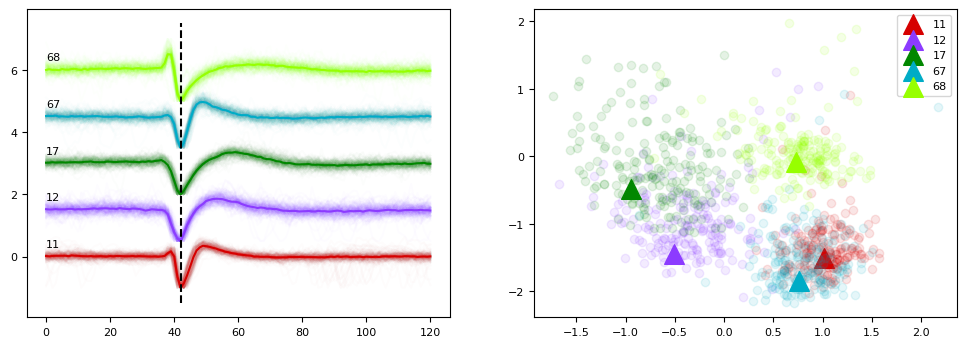

In [20]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
unit_ids = [11,12, 17, 67, 68]#, 45, 4, 5, 3, 22, 223]
# unit_ids = [211, 111, 121, 343]
# unit_ids = [11, 212, 331, 154, 198]
colors = cc.glasbey[:len(unit_ids)]
vertical_offset = 0
for i, unit_id in enumerate(unit_ids):
    unit_ceed_emb = fc_pca_ceed_emb[labels_nonzero==unit_id]
    unit_spikes = spikes_nonzero[labels_nonzero==unit_id]
    template = np.median(unit_spikes,0)
    template_emb = fc_celltype_ceed_5d.transform(torch.from_numpy(template).float()[None,None,:])
    pc_template_emb = fc_pca_ceed.transform(template_emb[:,None].T)[0]
    axes[0].plot(unit_spikes.T + vertical_offset, color=colors[i], alpha=.01);
    axes[0].plot(template.T + vertical_offset, color=colors[i], alpha=1);
    axes[0].annotate(str(unit_id), xy=(0,vertical_offset+.3))
    vertical_offset += 1.5
    axes[1].scatter(unit_ceed_emb[:,0], unit_ceed_emb[:,1], color=colors[i], alpha=.1)
    # axes[1].scatter(np.median(unit_ceed_emb,0)[0], np.median(unit_ceed_emb,0)[1], color=colors[i], alpha=1,marker='*', s=200, label=str(unit_id))
    axes[1].scatter(pc_template_emb[0], pc_template_emb[1], color=colors[i], alpha=1,marker="^", s=200, label=str(unit_id))
    # axes[2].scatter(pc_template_emb[0], pc_template_emb[1], pc_template_emb[2], color=colors[i], alpha=.1)
axes[0].vlines([42], ymax=vertical_offset, ymin= -1.5, ls='--', color='black')
plt.legend();

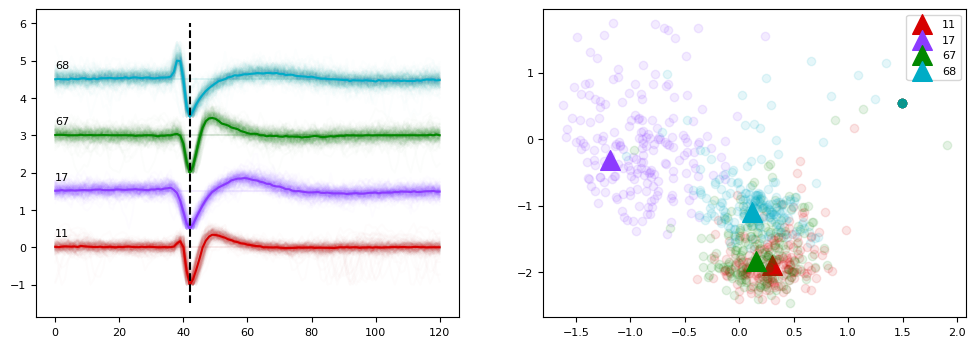

In [17]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
unit_ids = [11, 17, 67, 68]#, 45, 4, 5, 3, 22, 223]
# unit_ids = [211, 111, 121, 343]
# unit_ids = [11, 212, 331, 154, 198]
colors = cc.glasbey[:len(unit_ids)]
vertical_offset = 0
for i, unit_id in enumerate(unit_ids):
    unit_ceed_emb = fc_pca_ceed_emb[labels_nonzero==unit_id]
    unit_spikes = spikes_nonzero[labels_nonzero==unit_id]
    template = np.median(unit_spikes,0)
    template_emb = fc_celltype_ceed_5d.transform(torch.from_numpy(template).float()[None,None,:])
    pc_template_emb = fc_pca_ceed.transform(template_emb[:,None].T)[0]
    axes[0].plot(unit_spikes.T + vertical_offset, color=colors[i], alpha=.01);
    axes[0].plot(template.T + vertical_offset, color=colors[i], alpha=1);
    axes[0].annotate(str(unit_id), xy=(0,vertical_offset+.3))
    vertical_offset += 1.5
    axes[1].scatter(unit_ceed_emb[:,0], unit_ceed_emb[:,1], color=colors[i], alpha=.1)
    # axes[1].scatter(np.median(unit_ceed_emb,0)[0], np.median(unit_ceed_emb,0)[1], color=colors[i], alpha=1,marker='*', s=200, label=str(unit_id))
    axes[1].scatter(pc_template_emb[0], pc_template_emb[1], color=colors[i], alpha=1,marker="^", s=200, label=str(unit_id))
    # axes[2].scatter(pc_template_emb[0], pc_template_emb[1], pc_template_emb[2], color=colors[i], alpha=.1)
axes[0].vlines([42], ymax=vertical_offset, ymin= -1.5, ls='--', color='black')
plt.legend();

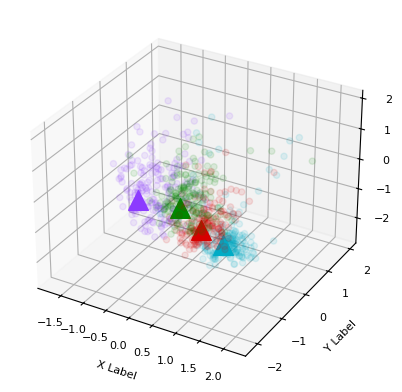

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
unit_ids = [11, 17, 67, 68]#, 45, 4, 5, 3, 22, 223]
colors = cc.glasbey[:len(unit_ids)]
vertical_offset = 0
for i, unit_id in enumerate(unit_ids):
    unit_ceed_emb = fc_pca_ceed_emb[labels_nonzero==unit_id]
    unit_spikes = spikes_nonzero[labels_nonzero==unit_id]
    template = np.median(unit_spikes,0)
    template_emb = fc_celltype_ceed_5d.transform(torch.from_numpy(template).float()[None,None,:])
    pc_template_emb = fc_pca_ceed.transform(template_emb[:,None].T)[0]
    ax.scatter(unit_ceed_emb[:,0], unit_ceed_emb[:,1], unit_ceed_emb[:,2], color=colors[i], alpha=.1)
    ax.scatter(pc_template_emb[0], pc_template_emb[1], pc_template_emb[2], color=colors[i], alpha=1,marker="^", s=200, label=str(unit_id))
    # axes[2].scatter(pc_template_emb[0], pc_template_emb[1], pc_template_emb[2], color=colors[i], alpha=.1)
# Adding labels
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Show plot
plt.show()

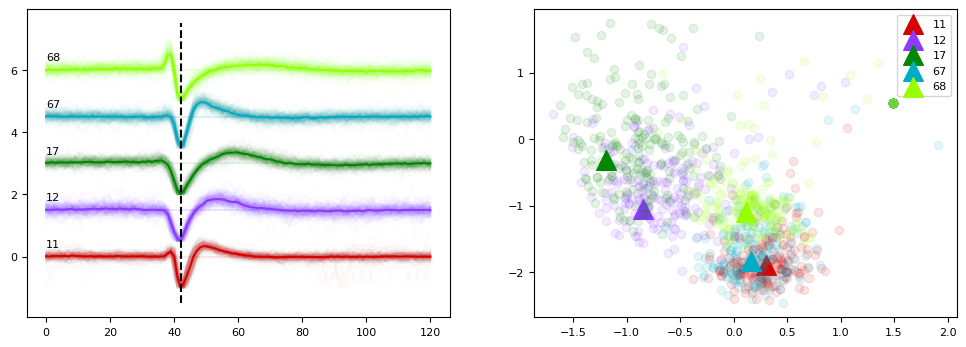

In [16]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
unit_ids = [11, 12, 17, 67, 68]#, 45, 4, 5, 3, 22, 223]
# unit_ids = [211, 111, 121, 343]
# unit_ids = [11, 212, 331, 154, 198]
colors = cc.glasbey[:len(unit_ids)]
vertical_offset = 0
for i, unit_id in enumerate(unit_ids):
    unit_ceed_emb = fc_pca_ceed_emb[labels_nonzero==unit_id]
    unit_spikes = spikes_nonzero[labels_nonzero==unit_id]
    template = np.median(unit_spikes,0)
    template_emb = fc_celltype_ceed_5d.transform(torch.from_numpy(template).float()[None,None,:])
    pc_template_emb = fc_pca_ceed.transform(template_emb[:,None].T)[0]
    axes[0].plot(unit_spikes.T + vertical_offset, color=colors[i], alpha=.01);
    axes[0].plot(template.T + vertical_offset, color=colors[i], alpha=1);
    axes[0].annotate(str(unit_id), xy=(0,vertical_offset+.3))
    vertical_offset += 1.5
    axes[1].scatter(unit_ceed_emb[:,0], unit_ceed_emb[:,1], color=colors[i], alpha=.1)
    # axes[1].scatter(np.median(unit_ceed_emb,0)[0], np.median(unit_ceed_emb,0)[1], color=colors[i], alpha=1,marker='*', s=200, label=str(unit_id))
    axes[1].scatter(pc_template_emb[0], pc_template_emb[1], color=colors[i], alpha=1,marker="^", s=200, label=str(unit_id))
axes[0].vlines([42], ymax=vertical_offset, ymin= -1.5, ls='--', color='black')
plt.legend();

NameError: name 'fc_umap_ceed_emb' is not defined

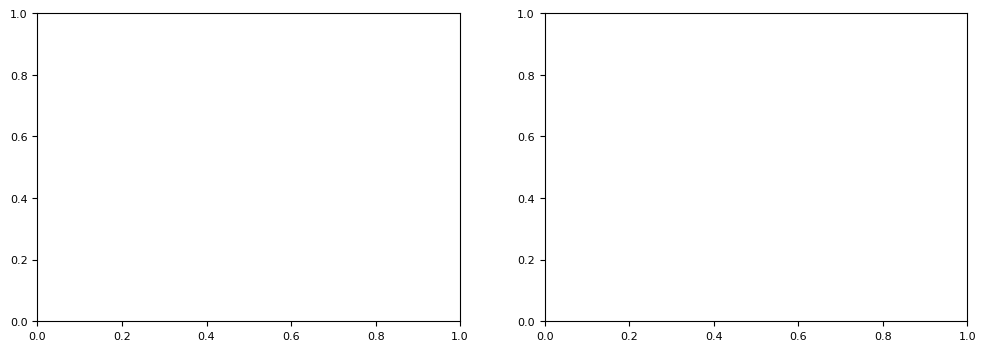

In [8]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
unit_ids = [11, 17, 67, 68]#, 45, 4, 5, 3, 22, 223]
unit_ids = [11, 12, 14, 18]#, 45, 4, 5, 3, 22, 223]
# unit_ids = [211, 111, 121, 343]
# unit_ids = [11, 212, 331, 154, 198]
colors = cc.glasbey[:len(unit_ids)]
vertical_offset = 0
for i, unit_id in enumerate(unit_ids):
    unit_ceed_emb = fc_umap_ceed_emb[labels_nonzero==unit_id]
    unit_spikes = spikes_nonzero[labels_nonzero==unit_id]
    template = np.median(unit_spikes,0)
    template_emb = fc_celltype_ceed_5d.transform(torch.from_numpy(template).float()[None,None,:])
    axes[0].plot(unit_spikes.T + vertical_offset, color=colors[i], alpha=.01);
    axes[0].plot(template.T + vertical_offset, color=colors[i], alpha=1);
    axes[0].annotate(str(unit_id), xy=(0,vertical_offset+.3))
    vertical_offset += 1.5
    axes[1].scatter(unit_ceed_emb[:,0], unit_ceed_emb[:,1], color=colors[i], alpha=.1)
    axes[1].scatter(np.median(unit_ceed_emb,0)[0], np.median(unit_ceed_emb,0)[1], color=colors[i], alpha=1,marker='*', s=200, label=str(unit_id))
    # axes[1].scatter(pc_template_emb[0], pc_template_emb[1], color=colors[i], alpha=1,marker="^", s=200, label=str(unit_id))
axes[0].vlines([42], ymax=vertical_offset, ymin= -1.5, ls='--', color='black')
plt.legend();

In [ ]:
# example cell loading a 400 neuron, 200 spike Transformer cell type model
celltype_tformer_ckpt_dir = '/home/av3016/ceed/runs/saved_models/400neur_200s_celltype_tformer'

celltype_ceed_tformer = CEED(num_extra_chans=0, out_dim=128, proj_dim=5, model_arch='gpt')
celltype_ceed_tformer.load(celltype_tformer_ckpt_dir)

In [ ]:
cell_type_inference_data = np.load(os.path.join(celltype_test_data, 'spikes_test.npy'))

# same output as two cells above, but takes in actual data
transformed_inference_data = celltype_ceed_5d.transform(cell_type_inference_data)

In [ ]:
# example cell training a 400 neuron, 200 spike MLP model
data_dir = '/home/av3016/ceed/datasets/real400n_200s'
exp_name = 'real400n_200s_CEEDtest'
log_dir = '/home/av3016/ceed/runs/logs/'
ckpt_dir = '/home/av3016/ceed/runs/saved_models/'
batch_size = 512

ceed_test = CEED(num_extra_chans=2)
ceed_test.train(data_dir=data_dir, exp_name=exp_name, log_dir=log_dir, ckpt_dir=ckpt_dir, batch_size=batch_size)